In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import scipy.stats as stats
import matplotlib.pyplot as plt
import var_ntime 

In [3]:
from WindPy import w
w.start()  # 默认命令超时时间为120秒，如需设置超时时间可以加入waitTime参数，例如waitTime=60,即设置命令超时时间为60秒
# print("WindPy是否已经登录成功:{}".format(w.isconnected()))  # 判断WindPy是否已经登录成功|

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
## 上证指数案例：
error_code, price = w.wsd("000001.SH", "close", "2001-01-01", "2021-01-05", "PriceAdj=F",usedf=True)
price=price.dropna(how="any")
price.index=pd.to_datetime(price.index)
logr=np.log(price).diff().dropna()
# logr=logr[logr.index.year>2010]

In [5]:
## 美元/人民币汇率案例

# error_code, price = w.wsd("USDCNY.EX", "close", "2001-01-01", "2021-01-06", "TradingCalendar=NBC",usedf=True)
# price=price.dropna(how="any")
# price.index=pd.to_datetime(price.index)
# logr=np.log(price).diff().dropna()
# logr=logr[logr.index.year>2010]
# logr.head()

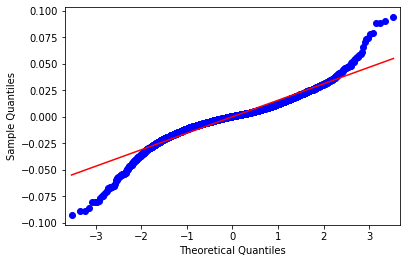

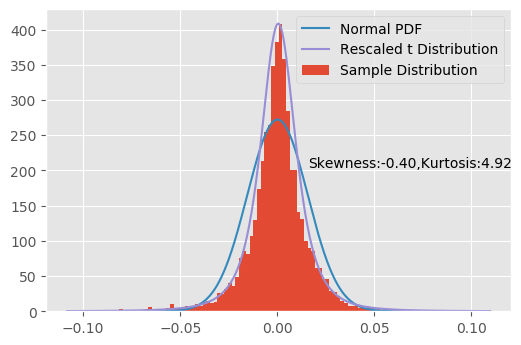

In [6]:
# check nomality with qplot
qplot1=qqplot(logr['CLOSE'],line='s')
# or with myhist
var_ntime.myhist(logr,bins=100)

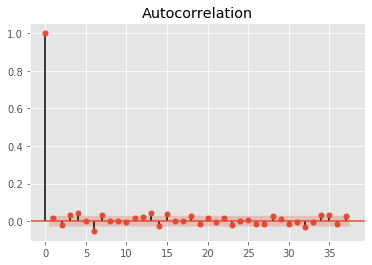

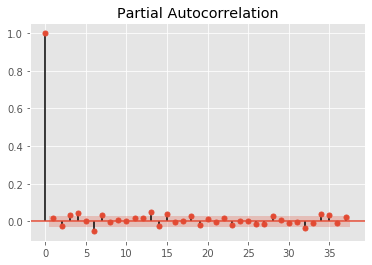

In [7]:
# Test the serial correlation with ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acfs=plot_acf(logr)
pacfs=plot_pacf(logr)

In [363]:
# we can calculate the acfs and pacfs
import statsmodels.api as sm
acfs=sm.tsa.acf(logr[logr.index.year>2018])
pacfs=sm.tsa.pacf(logr[logr.index.year>2018])
df=pd.DataFrame({"acfs":acfs,"pacfs":pacfs})
df.head()


,acfs,pacfs
0,1.000000,1.000000
1,0.039666,0.039747
2,0.003074,0.001509
3,0.070490,0.070855
4,-0.071181,-0.077901


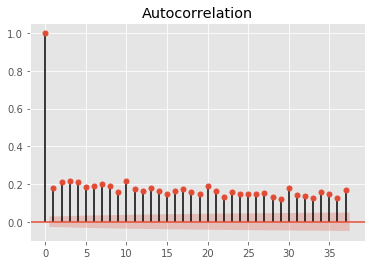

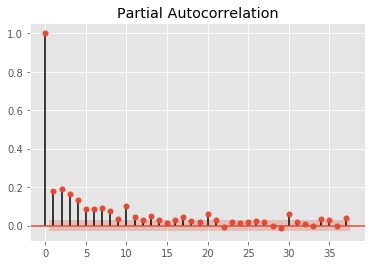

In [8]:
# check volatility clusering
# use  ACF or PACF of (abs(df))
acfs=plot_acf(logr.abs())
pacfs=plot_pacf(logr.abs())

In [9]:

from arch import arch_model
am = arch_model(logr,p=1,o=0,q=1,dist='normal')
# can use p-value for o to choose the optimal o
res = am.fit()
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -13990.61526669609
Iteration:      2,   Func. Count:     20,   Neg. LLF: -13990.769628877944
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -13990.769619897184
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
D:\Programs\anaconda3\lib\site-packages\arch\univariate\base.py:709: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  CLOSE   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                13990.8
Distribution:                  Normal   AIC:                          -27973.5
Method:            Maximum Likelihood   BIC:                          -27947.6
                                        No. Observations:                 4851
Date:                Mon, Jan 11 2021   Df Residuals:                     4847
Time:                        16:12:36   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.9966e-04  1.008e-05     19.801  2.916e-87 [1.799e-04,2.194e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.8454e-06  1.933e-11  2.507e+05      0.000 [4.845e-06,4.845e-06]
alpha[1]       0.1000  1.115e-02      8.969  2.985e-19   [7.815e-02,  0.122]
beta[1]        0.8800  9.091e-03     96.800      0.000     [  0.862,  0.898]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

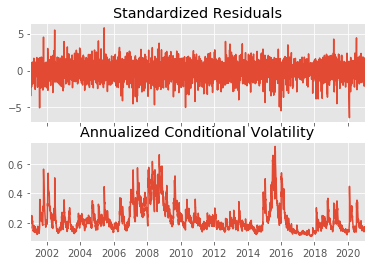

In [10]:
fig=res.plot(annualize='D')


In [367]:
# from arch import arch_model
# am = arch_model(logr,p=1,q=1,dist='t')
# res = am.fit()
# res.summary()
# fig=res.plot()

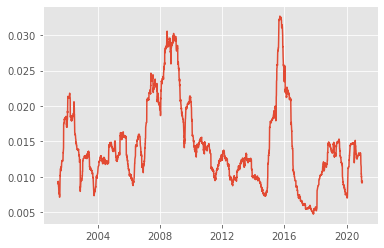

In [11]:
rolling_std=logr.rolling(window=100,min_periods=100).std()
plt.plot(rolling_std)

,CLOSE
2001-10-23,0.09401


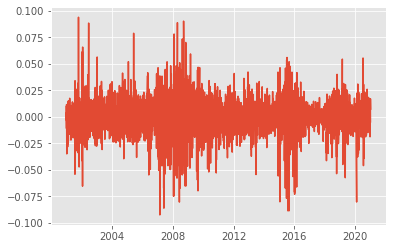

In [12]:
plt.plot(logr)
logr[logr['CLOSE']==logr['CLOSE'].max()]

In [14]:
myvars=logr.rolling(window=100,min_periods=100).apply(lambda t: var_ntime.myvar(t,alphas=0.05,method='norm',tell=False))

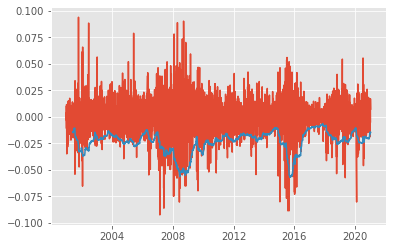

In [15]:
plt.plot(logr)
plt.plot(myvars)

In [16]:
suc=(logr<myvars).loc[myvars.dropna().index]
suc.mean()

CLOSE    0.051347
dtype: float64

In [373]:
for i in myvars.index.year.drop_duplicates().to_list():
    print(i)
    print(suc[suc.index.year==i].mean())

2001
CLOSE    0.107143
dtype: float64
2002
CLOSE    0.042194
dtype: float64
2003
CLOSE    0.029046
dtype: float64
2004
CLOSE    0.049383
dtype: float64
2005
CLOSE    0.016529
dtype: float64
2006
CLOSE    0.049793
dtype: float64
2007
CLOSE    0.086777
dtype: float64
2008
CLOSE    0.065041
dtype: float64
2009
CLOSE    0.061475
dtype: float64
2010
CLOSE    0.041322
dtype: float64
2011
CLOSE    0.057377
dtype: float64
2012
CLOSE    0.032922
dtype: float64
2013
CLOSE    0.05042
dtype: float64
2014
CLOSE    0.044898
dtype: float64
2015
CLOSE    0.081967
dtype: float64
2016
CLOSE    0.045082
dtype: float64
2017
CLOSE    0.045082
dtype: float64
2018
CLOSE    0.065844
dtype: float64
2019
CLOSE    0.032787
dtype: float64
2020
CLOSE    0.045267
dtype: float64
2021
CLOSE    0.0
dtype: float64


In [374]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_datetime',
 '_dep_name',
 '_dep_var',
 '_fit_indices',
 '_index',
 '_is_pandas',
 '_loglikelihood',
 '_model',
 '_names',
 '_nobs',
 '_optim_output',
 '_param_cov',
 '_params',
 '_r2',
 '_resid',
 '_volatility',
 'aic',
 'arch_lm_test',
 'bic',
 'conditional_volatility',
 'conf_int',
 'convergence_flag',
 'cov_type',
 'fit_start',
 'fit_stop',
 'forecast',
 'hedgehog_plot',
 'loglikelihood',
 'model',
 'nobs',
 'num_params',
 'optimization_result',
 'param_cov',
 'params',
 'plot',
 'pvalues',
 'resid',
 'rsquared',
 'rsquared_adj',
 'scale',
 'std_err',
 'std_resid',
 'summary',
 'tvalues']

DescribeResult(nobs=4851, minmax=(array([-0.09256085]), array([0.09400973])), mean=array([0.00010665]), variance=array([0.00024232]), skewness=array([-0.39894993]), kurtosis=array([4.92396062]))
DescribeResult(nobs=4851, minmax=(-6.397524057573681, 5.780342545979846), mean=-0.010931015169641314, variance=1.0116576252419638, skewness=-0.3117546377111514, kurtosis=2.598620649186886)


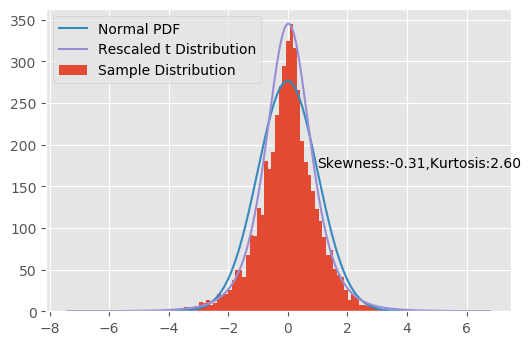

In [17]:
# diagnostic test
print(stats.stats.describe(logr))
print(stats.stats.describe(res.std_resid))
var_ntime.myhist(res.std_resid,bins=100)

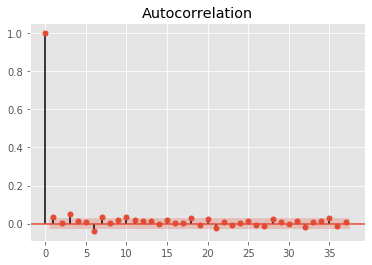

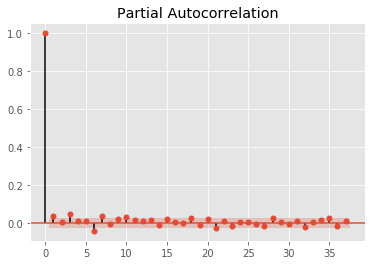

In [18]:
# diagnostic test
# serial correlation check
fig1=plot_acf(res.std_resid)
fig2=plot_pacf(res.std_resid)

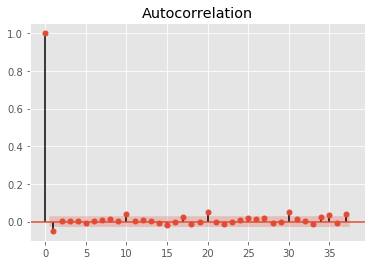

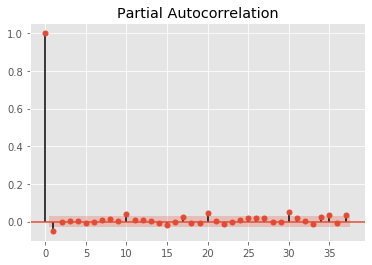

In [19]:
# diagnostic test
# volatility clustering check
fig1=plot_acf(res.std_resid.abs())
fig2=plot_pacf(res.std_resid.abs())

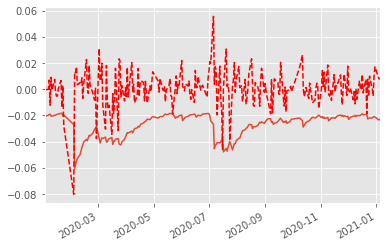

In [20]:
%matplotlib inline
zz=stats.t.ppf(0.05,df=4.01,loc=-0.017)
(zz*res.conditional_volatility[res.conditional_volatility.index.year>2019]).plot()
# plt.plot(-1.65*rolling_std[rolling_std.index.year>2019])
plt.plot(logr[logr.index.year>2019],"r--")


In [21]:
zz=stats.t.ppf(0.05,df=4.01,loc=-0.017)
aa=logr[logr.index.year>2019].iloc[:,0]
bb=(zz*res.conditional_volatility[res.conditional_volatility.index.year>2019])
xx=aa<bb

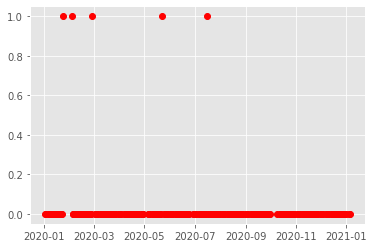

In [22]:
plt.plot(xx,"ro")

In [270]:
xx.mean()

0.044715447154471545

In [290]:
 np.sqrt(0.044375/(1-0.044344-0.5*0.036104-0.931280))

2.6489468985040543

In [336]:
## simulation
sim_mod = arch_model(None, p=1, o=0, q=1, dist="normal")
sim_data=sim_mod.simulate(res.params,nobs=1000)

In [337]:
res.params

mu          0.000200
omega       0.000005
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64

In [338]:
sim_data.head()

,data,volatility,errors
0,-0.005123,0.010681,-0.005322
1,-0.010096,0.010396,-0.010295
2,0.017602,0.010514,0.017403
3,0.013893,0.011507,0.013693
4,0.013331,0.011837,0.013131


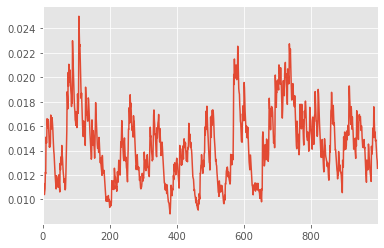

In [326]:
sim_data['volatility'].plot()

-1.021048298760847e-05

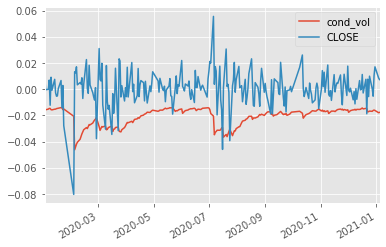

In [343]:
zzz=stats.norm.ppf(0.05)
vols=zzz*res.conditional_volatility[res.conditional_volatility.index.year>2019]
logrs=logr[logr.index.year>2019]
df=pd.concat([vols,logrs],1)
df.plot()

In [24]:
from arch import arch_model
import datetime as dt
am = arch_model(logr,p=1,o=0,q=1,dist='normal')
split_date = dt.datetime(2020,1,1)
# can use p-value for o to choose the optimal o
res = am.fit(last_obs=split_date)
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -13266.117817728857
Iteration:      2,   Func. Count:     20,   Neg. LLF: -13266.24209940208
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -13266.242085237722
            Iterations: 2
            Function evaluations: 31
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  CLOSE   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                13266.2
Distribution:                  Normal   AIC:                          -26524.5
Method:            Maximum Likelihood   BIC:                          -26498.7
                                        No. Observations:                 4606
Date:                Mon, Jan 11 2021   Df Residuals:                     4602
Time:                        16:16:46   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6733e-04  1.406e-05     11.905  1.115e-32 [1.398e-04,1.949e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.9205e-06  7.471e-12  6.586e+05      0.000 [4.920e-06,4.921e-06]
alpha[1]       0.1000  1.043e-02      9.592  8.676e-22   [7.957e-02,  0.120]
beta[1]        0.8800  8.724e-03    100.875      0.000     [  0.863,  0.897]
============================================================================

Covariance estimator: robust
"""

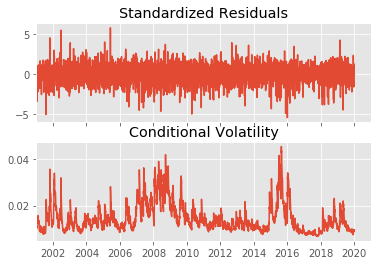

In [346]:
fig=res.plot()

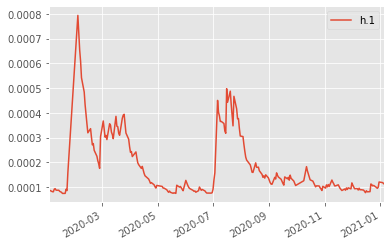

In [25]:
forecasts = res.forecast(horizon=1, start=split_date)
fig=forecasts.variance[split_date:].plot()